In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
print(trainset)
print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [4]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [24]:
# creating model,and defining optimizer and loss
model = ConvolutionalAutoencoder()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

We're using => cuda:0
ConvolutionalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [25]:
def output_label(label):
    output_mapping = {
                 0: "Zero",
                 1: "One",
                 2: "Two",
                 3: "Three",
                 4: "Four", 
                 5: "Five", 
                 6: "Six",
                 7: "Seven",
                 8: "Eight",
                 9: "Nine"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Four
torch.Size([64, 1, 28, 28]) torch.Size([64])


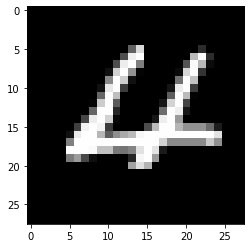

In [26]:
image, label = next(iter(train_loader))
plt.imshow(image[10].squeeze(), cmap="gray")
print(output_label(label[10]))
print(image.size(), label.size())

In [27]:
print("Begin training.")
for e in tqdm(range(5)):
    # TRAINING
    train_epoch_loss = 0
    #train_epoch_acc = 0
    batch_num = 1
    model.train()
    for X_train_batch, _ in tqdm(train_loader):
        X_train_batch = X_train_batch.to(device)
        optimizer.zero_grad()
        #X_train_batch = X_train_batch.view(X_train_batch.size(0), -1)
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, X_train_batch)
        #train_acc = Accuracy(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        #train_epoch_acc += train_acc.item()
        #print(f'{batch_num+0:02}: | Train Acc: {train_acc} | Train Loss: {train_loss.item()}')
        batch_num += 1
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f}')

Begin training.



Epoch 00: | Train Loss: 0.93439



Epoch 01: | Train Loss: 0.92537



Epoch 02: | Train Loss: 0.92537



Epoch 03: | Train Loss: 0.88918



Epoch 04: | Train Loss: 0.84816



In [28]:
def show_torch_image(torch_tensor):
    plt.imshow(torch_tensor.numpy(), cmap='gray')

In [29]:
#TESTING
model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #x_batch = x_batch.view(x_batch.size(0), -1)
        y_test_pred = model(x_batch)

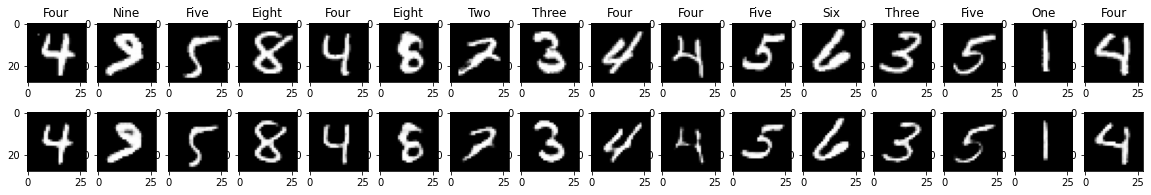

In [30]:
plt.figure(figsize=(20, 3))
for i in range(16):
    plt.subplot(2, 16, i+1).set_title(output_label(y_batch[i]))
    show_torch_image(x_batch[i].cpu().squeeze())
for i in range(16):
    plt.subplot(2, 16, 16+i+1)
    show_torch_image(y_test_pred[i].detach().cpu().squeeze())